In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
%tensorflow_version 2.x
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__



'2.4.1'

In [10]:
DATA_LIST = os.listdir('/content/drive/MyDrive/all/train')
DATASET_PATH  = '/content/drive/MyDrive/all/train'
TEST_DIR =  '/content/drive/MyDrive/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


In [12]:
#vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
#vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))
mobile = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape = (224,224,3))
model2 = tf.keras.models.Sequential([
    mobile,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu',name='feature_dense'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
feature_dense (Dense)        (None, 256)               12845312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 16,075,204
Trainable params: 16,053,316
Non-trainable params: 21,888
_________________________________________________________________


In [18]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
history = model2.fit(train_batches, epochs=100, validation_data=valid_batches,batch_size=BATCH_SIZE, 
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 10s 364ms/step - loss: 0.2283 - accuracy: 0.8972 - val_loss: 0.7325 - val_accuracy: 0.8200
Epoch 2/100
21/21 [==============================] - 7s 335ms/step - loss: 0.2443 - accuracy: 0.9197 - val_loss: 0.8362 - val_accuracy: 0.8000
Epoch 3/100
21/21 [==============================] - 7s 339ms/step - loss: 0.4188 - accuracy: 0.9062 - val_loss: 0.7468 - val_accuracy: 0.7600
Epoch 4/100
21/21 [==============================] - 7s 338ms/step - loss: 0.2436 - accuracy: 0.9339 - val_loss: 1.0566 - val_accuracy: 0.7800
Epoch 5/100
21/21 [==============================] - 7s 341ms/step - loss: 0.2662 - accuracy: 0.9183 - val_loss: 0.9426 - val_accuracy: 0.7200
Epoch 6/100
21/21 [==============================] - 7s 331ms/step - loss: 0.4100 - accuracy: 0.8720 - val_loss: 0.5798 - val_accuracy: 0.7800
Epoch 7/100
21/21 [==============================] - 7s 337ms/step - loss: 0.5677 - accuracy: 0.8446 - val_loss: 0.7116 - val_accuracy: 0.800

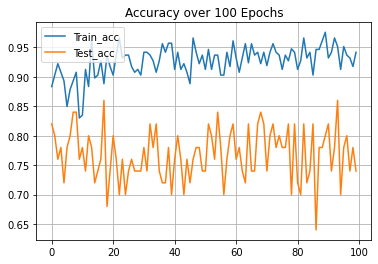

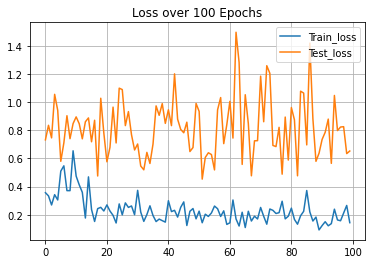

In [19]:
import matplotlib.pyplot as plt

plt.title('Accuracy over 100 Epochs')
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Test_acc')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.title('Loss over 100 Epochs')
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Test_loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [20]:
#vgg16.trainable = True
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model2.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
 9/36 [======>.......................] - ETA: 0s - loss: 0.9076 - accuracy: 0.8889

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 1s 22ms/step - loss: 0.7996 - accuracy: 0.7778
Test loss: 0.7996049523353577
Test accuracy: 0.7777777910232544


Found 270 images belonging to 4 classes.


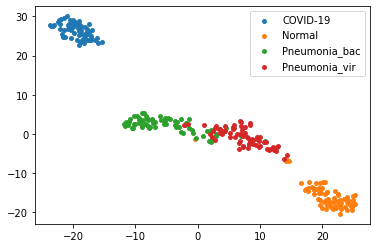

In [22]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model2.input,
                                        outputs=model2.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")


#get labels from data generator
labels_array = []
num_labels=[]
a = tsne_eval_generator.class_indices.keys()
for i in range( tsne_eval_generator.__len__() ):
    labels_array.extend(tsne_eval_generator.__getitem__( i )[1] )   #obtain the arrays of index to array
    for j in range(len(labels_array[i])):       #obtain the index of item that is equal to 1, and append to the list 
        if labels_array[i][j] == 1.0:
            num_labels.append(j)

#feature extraction    
tsne_eval_generator.reset()
features = intermediate_layer_model.predict(tsne_eval_generator)

#compress the dimensionality    
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(features)
x=[i[0] for i in tsne_result]
y=[i[1] for i in tsne_result]

#plotting values
zero_x=[]
one_x=[]
two_x=[]
three_x=[]

zero_y=[]
one_y=[]
two_y=[]
three_y=[]

for i in range(len(labels_array)):
    if num_labels[i] == 0:
        zero_x.append(x[i])
        zero_y.append(y[i])
    elif num_labels[i] == 1:
        one_x.append(x[i])
        one_y.append(y[i])
    elif num_labels[i] == 2:
        two_x.append(x[i])
        two_y.append(y[i])
    elif num_labels[i] == 3:
        three_x.append(x[i])
        three_y.append(y[i])
        
        
#plotting
plt.scatter(zero_x,zero_y, label='COVID-19', s=15)
plt.scatter(one_x,one_y, label='Normal', s=15)
plt.scatter(two_x,two_y, label='Pneumonia_bac', s=15)
plt.scatter(three_x,three_y, label='Pneumonia_vir', s=15)
plt.legend(loc='upper right')
plt.show()

## SECOND MODEL
_____________________________________________________________________

In [ ]:
DATA_LIST = os.listdir('/content/drive/MyDrive/all/train')
DATASET_PATH  = '/content/drive/MyDrive/all/train'
TEST_DIR =  '/content/drive/MyDrive/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=False,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=False,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))
#vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape = (224,224,3))

model = tf.keras.models.Sequential([
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu',name='feature_dense'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
resnet.trainable = False
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
feature_dense (Dense)        (None, 256)               25690368  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
___________________

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
history = model.fit(train_batches, epochs=100, validation_data=valid_batches,batch_size=5, 
                    steps_per_epoch=STEP_SIZE_TRAIN, validation_steps = STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 11s 388ms/step - loss: 4.9182 - accuracy: 0.2570 - val_loss: 4.7717 - val_accuracy: 0.2000
Epoch 2/100
21/21 [==============================] - 7s 338ms/step - loss: 3.5806 - accuracy: 0.3073 - val_loss: 1.7655 - val_accuracy: 0.2400
Epoch 3/100
21/21 [==============================] - 7s 329ms/step - loss: 1.8203 - accuracy: 0.1904 - val_loss: 1.4088 - val_accuracy: 0.2800
Epoch 4/100
21/21 [==============================] - 7s 334ms/step - loss: 1.4273 - accuracy: 0.2443 - val_loss: 1.3861 - val_accuracy: 0.2800
Epoch 5/100
21/21 [==============================] - 7s 334ms/step - loss: 1.3864 - accuracy: 0.1199 - val_loss: 1.3863 - val_accuracy: 0.2400
Epoch 6/100
21/21 [==============================] - 7s 332ms/step - loss: 1.3864 - accuracy: 0.0922 - val_loss: 1.3862 - val_accuracy: 0.2800
Epoch 7/100
21/21 [==============================] - 7s 334ms/step - loss: 1.3862 - accuracy: 0.3363 - val_loss: 1.3863 - val_accuracy: 0.280

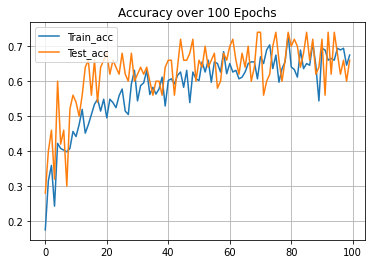

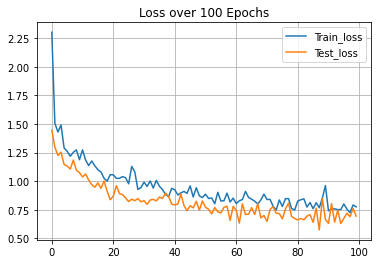

In [ ]:
import matplotlib.pyplot as plt

plt.title('Accuracy over 100 Epochs')
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label = 'Test_acc')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.title('Loss over 100 Epochs')
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label = 'Test_loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
vgg16.trainable = True
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
 2/36 [>.............................] - ETA: 2s - loss: 0.3269 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 1s 26ms/step - loss: 0.8772 - accuracy: 0.6111
Test loss: 0.8772103786468506
Test accuracy: 0.6111111044883728
